> Mathematical Engineering and Physics using Machine Learning, EE798Z

##### *November 25th, 2024*

## Course Project - Wind Power Forecasting

**Kartik Anant Kulkarni (Roll no. 210493)**


----



# Phase 2 - Exploiting ERA5: Turbine-Level Forecast Refinement

## Settings
1. Please setup the environment as per the requirements with appropriate package versions.
2. As the notebook uses interactive widgets, to fully see and understand all the outputs, it is better to run the notebook before going through the outputs.

## Imports

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
from ipywidgets import interact, interact_manual, fixed
from typing import List, Iterable, Tuple, Dict, Optional, Callable

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor

from scipy.stats import entropy
from skopt import BayesSearchCV
from vmdpy import VMD
from xgboost import XGBRegressor

import faiss

import tensorflow as tf
from dataclasses import dataclass
import pickle

## Configuration

In [2]:
FONT_SIZE_TICKS = 15
FONT_SIZE_TITLE = 25
FONT_SIZE_AXES = 20

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
SDWPF_RAW_PATH = "./../Datasets/SDWPF_dataset/sdwpf_full/sdwpf_2001_2112_full.csv"
TURBINE_LOC_PATH = (
    "./../Datasets/SDWPF_dataset/sdwpf_full/sdwpf_turb_location_elevation.csv"
)
OPEN_WEATHER_FORECASTS = "./../Datasets/wind_speed_analysis/weather_forecast.pkl"
IMAGES_DIR = "./../output"

## Dataset

The raw dataset has the following time series features. The target variable is active power.
| Column Name | Specification Note |
| --- | --- |
| TurbID | Wind turbine ID |
| Tmstamp | Created time of the record Time zone UTC + 08:00 |
| Wspd (m/s) | The wind speed at the top of the turbine Recorded by mechanical anemometer |
| Wdir(°) | Relative wind direction, which is the angle between the wind direction and the the turbine nacelle direction. Wind  direction and nacelle direction are in degrees from true north |
| Etmp | Temperature of the surrounding environment Measured outer surface of the nacelle |
| Itmp | Temperature inside the turbine nacelle |
| Ndir (°) | Nacelle direction, the yaw angle of the nacelle In degree from true north |
| Pab1 (°) | Pitch angle of blade 1 The angle between the chord line and the rotation plane of the blade |
| Pab2 (°) | Pitch angle of blade 2 Same as above |
| Pab3 (°) | Pitch angle of blade 3 Same as above |
| Prtv (kW) | Reactive power |
| T2m | Temperature at 2 m above surface (ERA5) |
| Sp (Pa) | Surface pressure from ERA5 |
| RelH | Relative humidity Derived based on 2 m dew point temperature and 2m temperature using Python Package metpy |
| Wspd_w (m/s) | Wind speed from ERA5 At height of 10 m |
| Wdir_w (°) | Wind direction from ERA5 At height of 10 m |
| Tp (m) | Total precipitation from ERA5 |
| Patv (kW) | Active power, the wind power produced by a wind turbine |
<!-- | Day | Day of the record | -->

The new data also has the geolocations of each turbines with the elevations.

In [5]:
raw_data = pd.read_csv(SDWPF_RAW_PATH)
raw_data.head(5)

,TurbID,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
0,57,2020-01-03 04:25:00,7.935,0.055,2.185,23.415,236.59,-0.840,-0.840,-0.845,29.680,-12.312683,85893.516,0.529154,5.191925,52.389540,0.0,976.925
1,57,2020-01-03 04:55:00,6.425,-1.860,2.945,23.550,236.59,-0.610,-0.605,-0.610,14.480,-12.312683,85893.516,0.529154,5.191925,52.389540,0.0,610.830
2,57,2020-01-03 05:25:00,5.945,-1.635,3.720,23.350,236.59,-0.435,-0.435,-0.435,15.270,-11.709015,85836.430,0.516070,5.563238,56.420248,0.0,483.850
3,57,2020-01-03 05:55:00,6.290,1.220,4.385,23.285,236.59,-0.510,-0.510,-0.510,19.030,-11.709015,85836.430,0.516070,5.563238,56.420248,0.0,536.970
4,57,2020-01-03 06:25:00,5.650,3.790,4.945,23.265,243.84,-0.355,-0.355,-0.355,9.795,-10.475830,85820.766,0.515158,6.000677,55.780818,0.0,431.700


In [6]:
raw_data["Tmstamp"] = pd.to_datetime(raw_data["Tmstamp"])
raw_data.sort_values(by=["Tmstamp", "TurbID"], inplace=True)

# Backward fill missing values (NANs), i.e. the missing value is substituted with the next available value
raw_data = raw_data.bfill()
# For the rest of the values drop the corresponding entries
raw_data = raw_data.dropna()

print("Number of missing values per feature:\n")
print(raw_data.isnull().sum())

Number of missing values per feature:

TurbID     0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
T2m        0
Sp         0
RelH       0
Wspd_w     0
Wdir_w     0
Tp         0
Patv       0
dtype: int64


In [7]:
numerical_features = [
    f for f in list(raw_data.columns) if f not in ["TurbID", "Day", "Tmstamp"]
]
descriptive_stats = raw_data[numerical_features].describe()
descriptive_stats.apply(lambda s: s.apply("{0:.3f}".format))

,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
count,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000
mean,4.937,1.154,27.668,24.475,168.231,27.037,27.024,27.021,-9.313,9.246,85431.534,0.336,4.877,165.715,0.000,360.687
std,3.486,32.809,64.349,19.276,170.842,39.071,39.057,39.056,63.059,13.746,637.330,0.183,2.452,108.270,0.000,434.937
min,0.000,-1075.040,-273.170,-273.170,-1083.700,-10.000,-10.000,-10.000,-734.880,-22.302,83845.830,0.025,0.037,0.008,0.000,-9.310
25%,2.110,-3.400,7.255,16.440,41.960,0.010,0.010,0.010,-21.660,-2.270,84930.400,0.191,3.152,71.553,0.000,-0.300
50%,4.140,-0.220,18.870,25.230,178.860,0.330,0.330,0.330,-0.300,10.100,85378.625,0.298,4.403,117.353,0.000,172.140
75%,7.010,3.350,30.010,34.830,303.100,85.310,85.250,85.270,0.000,20.953,85925.250,0.452,6.338,267.490,0.000,588.735
max,56.870,842.140,394.330,324.210,700.630,99.980,99.980,99.980,500.310,37.662,87489.220,0.988,16.113,359.984,0.002,1561.380


In [8]:
def top_n_turbines(
    raw_data: pd.core.frame.DataFrame, n: int
) -> pd.core.frame.DataFrame:
    """Keeps only the top n turbines that produced more energy on average.

    Args:
        raw_data (pd.core.frame.DataFrame): The full dataset.
        n (int): Desired number of turbines to keep.

    Returns:
        pd.core.frame.DataFrame: The dataset with only the data from the top n turbines.
    """
    sorted_patv_by_turbine = (
        raw_data.groupby("TurbID")
        .mean(numeric_only=True)["Patv"]
        .sort_values(ascending=False)
    )
    top_turbines = list(sorted_patv_by_turbine.index)[:n]
    print(
        f"Original data has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines.\n"
    )
    raw_data = raw_data[raw_data["TurbID"].isin(top_turbines)]
    print(
        f"Sliced data has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines."
    )
    return raw_data


top_turbines = top_n_turbines(raw_data, 10)

Original data has 11360922 rows from 134 turbines.

Sliced data has 847830 rows from 10 turbines.


In [9]:
def plot_time_series(df: pd.core.frame.DataFrame, features: List[str]):
    """Creates interactive plots for the time series in the dataset.

    Args:
        df (pd.core.frame.DataFrame): The data used.
        features (List[str]): Features to include in the plot.
    """

    def plot_time_series(turbine, feature, date_range, fix_temps):
        data = df[df.TurbID == turbine]
        if fix_temps:
            min_etemp = data["Etmp"].quantile(0.01)
            data["Etmp"] = data["Etmp"].apply(lambda x: np.nan if x < min_etemp else x)
            data["Etmp"] = data["Etmp"].interpolate()
            min_itemp = data["Itmp"].quantile(0.01)
            data["Itmp"] = data["Itmp"].apply(lambda x: np.nan if x < min_itemp else x)
            data["Itmp"] = data["Itmp"].interpolate()

        data = data[data.Tmstamp > date_range[0]]
        data = data[data.Tmstamp < date_range[1]]
        plt.figure(figsize=(15, 5))
        plt.plot(data["Tmstamp"], data[feature], "-")
        plt.title(f"Time series of {feature}", fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        plt.xlabel(f"Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.show()

    turbine_selection = widgets.Dropdown(
        options=df.TurbID.unique(),
        value=df.TurbID.unique()[-1],
        description="Turbine ID",
    )

    feature_selection = widgets.Dropdown(
        options=features,
        description="Feature",
    )

    start_date = pd.to_datetime("2020-05-01")
    end_date = pd.to_datetime("2020-12-31")

    dates = pd.date_range(start_date, end_date, freq="D")

    options = [(date.strftime("%b %d"), date) for date in dates]
    index = (0, len(options) - 1)

    date_slider_selection = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description="Date (2020)",
        orientation="horizontal",
        layout={"width": "550px"},
    )

    fix_temps_button = widgets.Checkbox(
        value=False, description="Fix Temperatures", disabled=False
    )

    interact(
        plot_time_series,
        turbine=turbine_selection,
        feature=feature_selection,
        date_range=date_slider_selection,
        fix_temps=fix_temps_button,
    )


plot_time_series(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine ID', index=9, options=(1, 3, 5, 6, 8, 9, 10, 11, 12, 26), …

In [10]:
def tag_abnormal_values(
    df: pd.core.frame.DataFrame, condition: pd.core.series.Series
) -> pd.core.frame.DataFrame:
    """Determines if a given record is an abnormal value.

    Args:
        df (pd.core.frame.DataFrame): The dataset used.
        condition (pd.core.series.Series): Series that includes if a record meets one of the conditions for being an abnormal value.

    Returns:
        pd.core.frame.DataFrame: Dataset with tagger abnormal values.
    """
    indexes = df[condition].index
    df.loc[indexes, "Include"] = False
    return df

In [11]:
# Initially include all rows
raw_data["Include"] = True

# Define conditions for abnormality
conditions = [
    np.isnan(raw_data.Patv),
    (raw_data.Pab1 > 89) | (raw_data.Pab2 > 89) | (raw_data.Pab3 > 89),
    (raw_data.Ndir < -720) | (raw_data.Ndir > 720),
    (raw_data.Wdir < -180) | (raw_data.Wdir > 180),
    (raw_data.Patv <= 0) & (raw_data.Wspd > 2.5),
]

# Exclude abnormal features
for condition in conditions:
    raw_data = tag_abnormal_values(raw_data, condition)

clean_data = raw_data[raw_data.Include].drop(["Include"], axis=1)
clean_data.head()

,TurbID,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
3077392,1,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05
3093504,2,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05
3109616,3,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05
3125728,4,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05
3141840,5,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05


### Feature Engineering

#### Blade Angles

Get rid of correlated Features Pab

In [12]:
def cut_pab_features(raw_data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Deletes redundant Pab features from dataset.

    Args:
        raw_data (pd.core.frame.DataFrame): The dataset used.

    Returns:
        pd.core.frame.DataFrame: The dataset without the redundant Pab features.
    """

    raw_data = raw_data.drop(["Pab2", "Pab3"], axis=1)
    raw_data = raw_data.rename(columns={"Pab1": "Pab"})

    return raw_data


clean_data = cut_pab_features(clean_data)

#### Angle Unit Change

There are 3 features (`Wdir`, `Ndir`, `Pab`) which are encoded in degrees. This is problematic because the model has no way of knowing that angles with very different values (such as 0° and 360°) are actually very similar (the same in this case) to each other. Thus transform them into `sine`/`cosine` representations.

In [13]:
def transform_angles(
    data: pd.core.frame.DataFrame, feature: str, drop_original: bool = True
):
    """Transform angles into their Sin/Cos encoding.

    Args:
        data (pd.core.frame.DataFrame): The dataset used.
        feature (str): Name of the angle feature.
        drop_original (bool, optional): Wheter to drop the original column from the dataset. Defaults to True.
    """
    rads = data[feature] * np.pi / 180

    data[f"{feature}Cos"] = np.cos(rads)
    data[f"{feature}Sin"] = np.sin(rads)

    if drop_original:
        data.drop(feature, axis=1, inplace=True)


for feature in ["Wdir_w", "Wdir", "Ndir", "Pab"]:
    transform_angles(clean_data, feature)

#### Temperature and Active Power

Both `Etmp` and `Itmp` have really negative values. In fact, these minimum values are very close to the absolute zero (-273.15 °C) which is most certainly an error. Use linear interpolation for the same.

Active power has negative values which doesn't make sense in the context of the problem at hand. The paper also addresses this issue by mentioning that all negative values should be treated as zero. 

In [14]:
def fix_temperatures(data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Replaces very low temperature values with linear interpolation.

    Args:
        data (pd.core.frame.DataFrame): The dataset.

    Returns:
        pd.core.frame.DataFrame: Dataset with fixed temperatures.
    """
    min_etemp = data["Etmp"].quantile(0.01)
    data["Etmp"] = data["Etmp"].apply(lambda x: np.nan if x < min_etemp else x)
    data["Etmp"] = data["Etmp"].interpolate()
    min_itemp = data["Itmp"].quantile(0.01)
    data["Itmp"] = data["Itmp"].apply(lambda x: np.nan if x < min_itemp else x)
    data["Itmp"] = data["Itmp"].interpolate()

    return data


clean_data = fix_temperatures(clean_data)
clean_data["Patv"] = clean_data["Patv"].apply(lambda x: max(0, x))

#### TOD Features

In [15]:
def generate_time_signals(raw_data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Creates time signal features (time-of-day) for the data.

    Args:
        raw_data (pd.core.frame.DataFrame): The dataset uded.

    Returns:
        pd.core.frame.DataFrame: The dataset with the new features.
    """
    if "Day sin" in raw_data.columns:
        return raw_data

    date_time = pd.to_datetime(raw_data.Tmstamp, format="%Y-%m-%d %H:%M")
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24 * 60 * 60

    raw_data["Time-of-day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
    raw_data["Time-of-day cos"] = np.cos(timestamp_s * (2 * np.pi / day))

    return raw_data


clean_data = generate_time_signals(clean_data)

In [16]:
clean_data

,TurbID,Tmstamp,Wspd,Etmp,Itmp,Prtv,T2m,Sp,RelH,Wspd_w,...,Wdir_wCos,Wdir_wSin,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Time-of-day sin,Time-of-day cos
3077392,1,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
3093504,2,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
3109616,3,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
3125728,4,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
3141840,5,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11203504,120,2021-12-31 23:50:00,2.46,1.55,10.56,-35.17,-12.468079,86241.92,0.577978,2.974639,...,0.999980,-0.006366,0.998763,0.049721,-0.939752,0.341856,1.000000,0.000175,-0.043619,0.999048
11256065,121,2021-12-31 23:50:00,2.26,-1.51,7.38,-44.18,-12.468079,86241.92,0.577978,2.974639,...,0.999980,-0.006366,0.998565,0.053556,0.834175,-0.551500,1.000000,0.000175,-0.043619,0.999048
11308626,122,2021-12-31 23:50:00,1.87,-1.11,7.60,-0.32,-12.468079,86241.92,0.577978,2.974639,...,0.999980,-0.006366,0.999180,0.040481,-0.249197,-0.968453,0.742093,0.670297,-0.043619,0.999048
10520211,129,2021-12-31 23:50:00,2.45,1.50,5.21,-0.30,-12.468079,86241.92,0.577978,2.974639,...,0.999980,-0.006366,0.960585,0.277985,0.601397,-0.798951,0.120483,0.992715,-0.043619,0.999048


### Resample - Hourly, Single Turbine

In [17]:
def prepare_data(df: pd.core.frame.DataFrame, turb_id: int) -> pd.core.frame.DataFrame:
    """Pre-process data before feeding to neural networks for training.
    This includes:
    - Resampling to an hourly basis
    - Using data from a single turbine
    - Format datetime
    - Mask abnormal values
    - Re-order columns

    Args:
        df (pandas.core.frame.DataFrame): The curated data from the previous lab.
        turb_id (int): ID of the turbine to use.

    Returns:
        pandas.core.frame.DataFrame: Processed dataframe.
    """
    df = df[5::6]
    df = df[df.TurbID == turb_id]
    df = df.drop(["TurbID"], axis=1)
    # df.set_index("Tmstamp", inplace=True)
    # # Ensure the index covers all the expected timestamps (for example, hourly)
    # full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="h")

    # # Reindex the DataFrame to the full range of timestamps, filling missing data with NaN
    # df = df.reindex(full_time_range)

    # # Handle missing values before resampling:
    # # Fill missing values with forward fill or any other method (e.g., zero, interpolation)
    # df = df.ffill()  # Forward-fill NaNs
    # df = df.resample("h").mean()
    # assert df.isnull().sum().sum() == 0
    df.index = pd.to_datetime(df.pop("Tmstamp"), format="%Y-%m-%d %H:%M")

    df = df[
        [
            "Wspd",
            "Etmp",
            "Itmp",
            "Prtv",
            "T2m",
            "Sp",
            "RelH",
            "Wspd_w",
            "Tp",
            "WdirCos",
            "WdirSin",
            "NdirCos",
            "NdirSin",
            "PabCos",
            "PabSin",
            "Time-of-day sin",
            "Time-of-day cos",
            "Wdir_wCos",
            "Wdir_wSin",
            "Patv",
        ]
    ]

    return df


turb_id = 6
data = prepare_data(clean_data, turb_id)
data.head(5)

,Wspd,Etmp,Itmp,Prtv,T2m,Sp,RelH,Wspd_w,Tp,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Time-of-day sin,Time-of-day cos,Wdir_wCos,Wdir_wSin,Patv
Tmstamp,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048,0.115677,0.993287,1503.05
2020-01-01 00:55:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.237686,0.971342,0.115677,0.993287,1503.05
2020-01-01 01:40:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.422618,0.906308,0.115677,0.993287,1503.05
2020-01-01 02:25:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.591310,0.806445,0.115677,0.993287,1503.05
2020-01-01 03:10:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.737277,0.675590,0.115677,0.993287,1503.05


### Split Data into Train, Validation and Test Sets

In [18]:
@dataclass
class DataSplits:
    """Class to encapsulate normalized/unnormalized train, val, test, splits."""

    train_data: pd.core.frame.DataFrame
    val_data: pd.core.frame.DataFrame
    test_data: pd.core.frame.DataFrame
    train_mean: pd.core.series.Series
    train_std: pd.core.series.Series
    train_df_unnormalized: pd.core.frame.DataFrame
    val_df_unnormalized: pd.core.frame.DataFrame
    test_df_unnormalized: pd.core.frame.DataFrame


def normalize_data(
    train_data: pd.core.frame.DataFrame,
    val_data: pd.core.frame.DataFrame,
    test_data: pd.core.frame.DataFrame,
) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, pd.core.series.Series, pd.core.series.Series
]:
    """Normalizes train, val and test splits.

    Args:
        train_data (pd.core.frame.DataFrame): Train split.
        val_data (pd.core.frame.DataFrame): Validation split.
        test_data (pd.core.frame.DataFrame): Test split.

    Returns:
        tuple: Normalized splits with training mean and standard deviation.
    """
    train_mean = train_data.mean()
    train_std = train_data.std()

    train_data = (train_data - train_mean) / train_std
    val_data = (val_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std

    return train_data, val_data, test_data, train_mean, train_std


def train_val_test_split(df: pd.core.frame.DataFrame) -> DataSplits:
    """Splits a dataframe into train, val and test.

    Args:
        df (pd.core.frame.DataFrame): The data to split.

    Returns:
        data_splits (DataSplits): An instance that encapsulates normalized/unnormalized splits.
    """
    n = len(df)
    train_df = df[0 : int(n * 0.7)]
    val_df = df[int(n * 0.7) : int(n * 0.9)]
    test_df = df[int(n * 0.9) :]

    train_df_un = train_df.copy(deep=True)
    val_df_un = val_df.copy(deep=True)
    test_df_un = test_df.copy(deep=True)

    train_df_un = train_df_un.mask(train_df_un.Patv == -1, np.nan)
    val_df_un = val_df_un.mask(val_df_un.Patv == -1, np.nan)
    test_df_un = test_df_un.mask(test_df_un.Patv == -1, np.nan)

    train_df, val_df, test_df, train_mn, train_st = normalize_data(
        train_df, val_df, test_df
    )

    ds = DataSplits(
        train_data=train_df,
        val_data=val_df,
        test_data=test_df,
        train_mean=train_mn,
        train_std=train_st,
        train_df_unnormalized=train_df_un,
        val_df_unnormalized=val_df_un,
        test_df_unnormalized=test_df_un,
    )

    return ds

In [19]:
data_splits = train_val_test_split(data)

print("training, validation and testing splits successfully created and normalized.")

training, validation and testing splits successfully created and normalized.


## Baseline

In [20]:
def compute_metrics(
    true_series: np.ndarray, forecast: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Computes MSE and MAE between two time series.

    Args:
        true_series (np.ndarray): True values.
        forecast (np.ndarray): Forecasts.

    Returns:
        tuple: MSE and MAE metrics.
    """

    mse = tf.keras.losses.MSE(true_series, forecast).numpy()
    mae = tf.keras.losses.MAE(true_series, forecast).numpy()

    return mse, mae

In [21]:
class WindowGenerator:
    """Class that handles all of the windowing and plotting logic for time series."""

    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df,
        val_df,
        test_df,
        label_columns=["Patv"],
    ):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col="Patv", max_subplots=1):
        inputs, labels = self.example
        plt.figure(figsize=(20, 6))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.title(
                "Inputs (past) vs Labels (future predictions)", fontsize=FONT_SIZE_TITLE
            )
            plt.ylabel(f"{plot_col} (normalized)", fontsize=FONT_SIZE_AXES)
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                color="green",
                linestyle="--",
                label="Inputs",
                marker="o",
                markersize=10,
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(
                self.label_indices,
                labels[n, :, label_col_index],
                color="orange",
                linestyle="--",
                label="Labels",
                markersize=10,
                marker="o",
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="*",
                    edgecolors="k",
                    label="Predictions",
                    c="pink",
                    s=64,
                )
            plt.legend(fontsize=FONT_SIZE_TICKS)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.xlabel("Timestep", fontsize=FONT_SIZE_AXES)

    def plot_long(
        self,
        model,
        data_splits,
        plot_col="Patv",
        time_steps_future=1,
        baseline_mae=None,
    ):
        train_mean, train_std = data_splits.train_mean, data_splits.train_std
        self.test_size = len(self.test_df)
        self.test_data = self.make_test_dataset(self.test_df, self.test_size)

        inputs, labels = next(iter(self.test_data))

        plt.figure(figsize=(20, 6))
        plot_col_index = self.column_indices[plot_col]

        plt.ylabel(f"{plot_col} (kW)", fontsize=FONT_SIZE_AXES)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        labels = (labels * train_std.Patv) + train_mean.Patv

        upper = 24 - (time_steps_future - 1)
        lower = self.label_indices[-1] - upper
        self.label_indices_long = self.test_df.index[lower:-upper]

        plt.plot(
            self.label_indices_long[:],
            labels[:, time_steps_future - 1, label_col_index][:],
            label="Labels",
            c="green",
        )

        if model is not None:
            predictions = model(inputs)
            predictions = (predictions * train_std.Patv) + train_mean.Patv
            predictions_for_timestep = predictions[
                :, time_steps_future - 1, label_col_index
            ][:]
            predictions_for_timestep = tf.nn.relu(predictions_for_timestep).numpy()
            plt.plot(
                self.label_indices_long[:],
                predictions_for_timestep,
                label="Predictions",
                c="orange",
                linewidth=3,
            )
            plt.legend(fontsize=FONT_SIZE_TICKS)
            _, mae = compute_metrics(
                labels[:, time_steps_future - 1, label_col_index][:],
                predictions_for_timestep,
            )

            if baseline_mae is None:
                baseline_mae = mae

            print(
                f"\nMean Absolute Error (kW): {mae:.2f} for forecast.\n\nImprovement over random baseline: {100*((baseline_mae -mae)/baseline_mae):.2f}%"
            )
        plt.title("Predictions vs Real Values for Test Split", fontsize=FONT_SIZE_TITLE)
        plt.xlabel("Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        return mae

    def make_test_dataset(self, data, bs):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=bs,
        )

        ds = ds.map(self.split_window)

        return ds

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, "_example", None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result


def generate_window(
    train_df: pd.core.frame.DataFrame,
    val_df: pd.core.frame.DataFrame,
    test_df: pd.core.frame.DataFrame,
    days_in_past: int,
    width: int = 24,
) -> WindowGenerator:
    """Creates a windowed dataset given the train, val, test splits and the number of days into the past.

    Args:
        train_df (pd.core.frame.DataFrame): Train split.
        val_df (pd.core.frame.DataFrame): Val Split.
        test_df (pd.core.frame.DataFrame): Test split.
        days_in_past (int): How many days into the past will be used to predict the next 24 hours.

    Returns:
        WindowGenerator: The windowed dataset.
    """
    OUT_STEPS = 24
    multi_window = WindowGenerator(
        input_width=width * days_in_past,
        label_width=OUT_STEPS,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        shift=OUT_STEPS,
    )
    return multi_window

### Method 1 - Uniformly Random Forecast


Mean Absolute Error (kW): 468.37 for forecast.

Improvement over random baseline: 0.00%


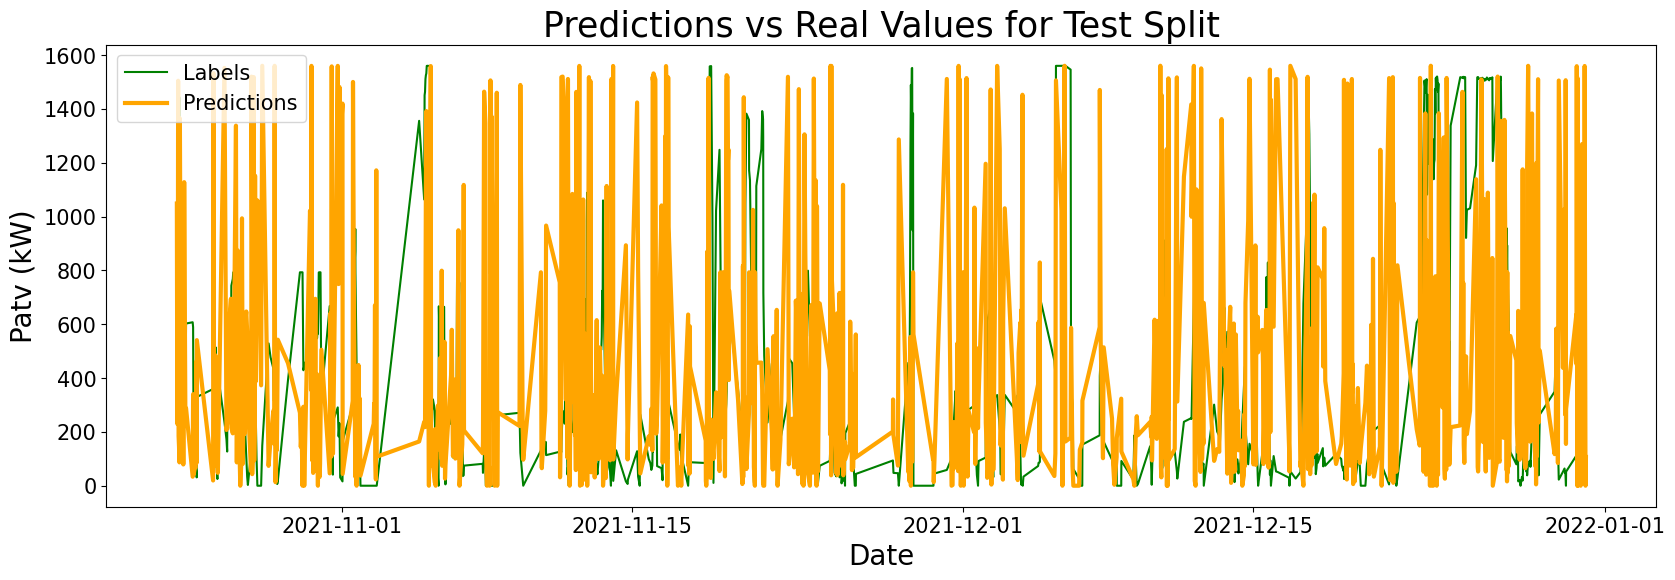

In [22]:
def random_forecast(
    data_splits: DataSplits, n_days: int = 1
) -> Tuple[WindowGenerator, tf.keras.Model]:
    """Generates a random forecast for a time window.

    Args:
        data_splits (DataSplits): The data to be used.
        n_days (int, optional): Period from which to draw the random values. Defaults to 1.

    Returns:
        tuple: The windowed dataset and the model that handles the forecasting logic.
    """
    train_data, val_data, test_data = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
    )

    random_window = generate_window(train_data, val_data, test_data, n_days)

    class randomBaseline(tf.keras.Model):
        def call(self, inputs):
            tf.random.set_seed(424)
            np.random.seed(424)
            random.seed(424)
            stacked = tf.random.shuffle(inputs)

            return stacked[:, :, -1:]

    random_baseline = randomBaseline()
    random_baseline.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    return random_window, random_baseline


random_window, random_baseline = random_forecast(data_splits)
random_baseline_mae = random_window.plot_long(random_baseline, data_splits)

### Method 2 - Replicate Yesterday's Behaviour

Window size throughout the notebook is kept at 24 hrs (1 day) for consistenvy of analysis.

In [23]:
def repeat_forecast(
    data_splits: DataSplits, shift: int = 24
) -> Tuple[WindowGenerator, tf.keras.Model]:
    """Performs a repeated forecast logic.

    Args:
        data_splits (DataSplits): The data to be used.
        n_days (int): Period to repeat.

    Returns:
        tuple: The windowed dataset and the model that handles the forecasting logic.
    """
    train_data, val_data, test_data = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
    )
    repeat_window = generate_window(train_data, val_data, test_data, 1, shift)

    class RepeatBaseline(tf.keras.Model):
        def call(self, inputs):
            return inputs[:, :, -1:]

    repeat_baseline = RepeatBaseline()
    repeat_baseline.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    return repeat_window, repeat_baseline


def interact_repeat_forecast(data_splits: DataSplits, baseline_mae: float) -> None:
    """Plot an interactive visualization of predictions vs true values.

    Args:
        func (Callable): Function to close over. Should be the plot_long method from the WindowGenerator instance.
        model (tf.keras.Model): The trained model.
        data_splits (DataSplits): The data used.
        baseline_mae (float): MAE of baseline to compare against.
    """

    def _plot(shift):
        repeat_window, repeat_baseline = repeat_forecast(data_splits, shift=shift)
        _ = repeat_window.plot_long(
            repeat_baseline, data_splits, baseline_mae=baseline_mae
        )

    shift_selection = widgets.IntSlider(
        value=24,
        min=1,
        max=24,
        step=1,
        description="Hours into future",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
        readout_format="d",
        layout={"width": "500px"},
        style={"description_width": "initial"},
    )

    interact(_plot, shift=shift_selection)


interact_repeat_forecast(data_splits, baseline_mae=random_baseline_mae)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### Method 3 - Moving Average Forecasts

In [24]:
def moving_avg_forecast(
    data_splits: DataSplits, n_days: int
) -> Tuple[WindowGenerator, tf.keras.Model]:
    """Performs a moving average forecast logic.

    Args:
        data_splits (DataSplits): The data to be used.
        n_days (int): Period to repeat.

    Returns:
        tuple: The windowed dataset and the model that handles the forecasting logic.
    """
    train_data, val_data, test_data = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
    )
    moving_avg_window = generate_window(train_data, val_data, test_data, n_days)

    class avgBaseline(tf.keras.Model):
        def call(self, inputs):
            m = tf.math.reduce_mean(inputs, axis=1)
            stacked = tf.stack([m for _ in range(inputs.shape[1])], axis=1)

            return stacked[:, :, -1:]

    moving_avg_baseline = avgBaseline()
    moving_avg_baseline.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    return moving_avg_window, moving_avg_baseline


def prediction_plot(
    func: Callable, model: tf.keras.Model, data_splits: DataSplits, baseline_mae: float
) -> None:
    """Plot an interactive visualization of predictions vs true values.

    Args:
        func (Callable): Function to close over. Should be the plot_long method from the WindowGenerator instance.
        model (tf.keras.Model): The trained model.
        data_splits (DataSplits): The data used.
        baseline_mae (float): MAE of baseline to compare against.
    """

    def _plot(time_steps_future):
        mae = func(
            model,
            data_splits,
            time_steps_future=time_steps_future,
            baseline_mae=baseline_mae,
        )

    time_steps_future_selection = widgets.IntSlider(
        value=24,
        min=1,
        max=24,
        step=1,
        description="Hours into future",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
        readout_format="d",
        layout={"width": "500px"},
        style={"description_width": "initial"},
    )

    interact(_plot, time_steps_future=time_steps_future_selection)


moving_avg_window, moving_avg_baseline = moving_avg_forecast(data_splits, n_days=1)
prediction_plot(
    moving_avg_window.plot_long,
    moving_avg_baseline,
    data_splits,
    baseline_mae=random_baseline_mae,
)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## Wind-Speed Forecast Refinement

In [25]:
def create_model(num_features: int, days_in_past: int) -> tf.keras.Model:
    """Creates a Conv-LSTM model for time series prediction.

    Args:
        num_features (int): Number of features used for prediction.
        days_in_past (int): Number of days into the past to predict next 24 hours.

    Returns:
        tf.keras.Model: The uncompiled model.
    """
    CONV_WIDTH = 3
    OUT_STEPS = 24

    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(days_in_past * 24, num_features)),
            tf.keras.layers.Masking(mask_value=-1.0),
            tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(32, return_sequences=True)
            ),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(32, return_sequences=False)
            ),
            tf.keras.layers.Dense(
                OUT_STEPS * 1, kernel_initializer=tf.initializers.zeros()
            ),
            tf.keras.layers.Reshape([OUT_STEPS, 1]),
        ]
    )

    return model


def compile_and_fit(
    model: tf.keras.Model, window: WindowGenerator, patience: int = 2
) -> tf.keras.callbacks.History:
    """Compiles and trains a model given a patience threshold.

    Args:
        model (tf.keras.Model): The model to train.
        window (WindowGenerator): The windowed data.
        patience (int, optional): Patience threshold to stop training. Defaults to 2.

    Returns:
        tf.keras.callbacks.History: The training history.
    """
    EPOCHS = 20

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
    )

    tf.random.set_seed(432)
    np.random.seed(432)
    random.seed(432)

    history = model.fit(
        window.train,
        epochs=EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )

    if len(history.epoch) < EPOCHS:
        print(
            "\nTraining stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps."
        )

    return history


def train_conv_lstm_model(
    data: pd.core.frame.DataFrame, features: List[str], days_in_past: int
) -> Tuple[WindowGenerator, tf.keras.Model, DataSplits]:
    """Trains the Conv-LSTM model for time series prediction.

    Args:
        data (pd.core.frame.DataFrame): The dataframe to be used.
        data (list[str]): The features to use for forecasting.
        days_in_past (int): How many days in the past to use to forecast the next 24 hours.

    Returns:
        tuple: The windowed dataset, the model that handles the forecasting logic and the data used.
    """
    data_splits = train_val_test_split(data[features])

    train_data, val_data, test_data, train_mean, train_std = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
        data_splits.train_mean,
        data_splits.train_std,
    )

    window = generate_window(train_data, val_data, test_data, days_in_past)
    num_features = window.train_df.shape[1]

    model = create_model(num_features, days_in_past)
    history = compile_and_fit(model, window)

    return window, model, data_splits

In [26]:
def load_weather_forecast() -> Dict[str, Dict[List[datetime], List[float]]]:
    """Loads the wind data and forecast for three locations and returns it in a form of dictionary."""
    with open(OPEN_WEATHER_FORECASTS, "rb") as f:
        weather_forecasts = pickle.load(f)
    return weather_forecasts


def prepare_wind_data(
    dates0: List[datetime],
    dates1: List[datetime],
    winds0: List[float],
    winds1: List[float],
    min_bound: Optional[str] = None,
    max_bound: Optional[str] = None,
) -> Tuple[List[datetime], List[datetime], List[float], List[float]]:
    """Takes in two datasets of wind data.
    Finds the data points that appear in both datasets (at the same time) and are between the specified time bounds.

    Args:
        dates0 (list): list of dates for the first dataset
        dates1 (list): list of dates for the second dataset
        winds0 (list): list of wind speed for the first dataset (corresponding to dates0)
        winds1 (list): list of wind speed for the second dataset (corresponding to dates1)
        min_bound (datetime): minimum bound for plotting
        max_bound (datetime): maximum bound for plotting
    """
    winds0_overlap = []
    winds1_overlap = []
    dates0_overlap = []
    dates1_overlap = []

    # Only take the dates that are in both datasets and within the limits if specified
    for date, wind in zip(dates0, winds0):
        if (
            date in dates1
            and (min_bound is None or date > min_bound)
            and (max_bound is None or date < max_bound)
        ):
            winds0_overlap.append(wind)
            dates0_overlap.append(date)
    for date, wind in zip(dates1, winds1):
        if (
            date in dates0
            and (min_bound is None or date > min_bound)
            and (max_bound is None or date < max_bound)
        ):
            winds1_overlap.append(wind)
            dates1_overlap.append(date)

    return dates0_overlap, dates1_overlap, winds0_overlap, winds1_overlap


def plot_forecast(
    weather_forecasts: Dict[str, Dict[List[datetime], List[float]]]
) -> None:
    """Creates an interactive plot of true values vs forecasts for the wind data.

    Args:
        weather_forecasts (dict): History of weather and weather forecasts.
    """

    def _plot(city, time_steps_future):
        format_timestamp = "%Y-%m-%d %H:%M:%S"

        weather_forecast = weather_forecasts[city]

        dates_real, winds_real = weather_forecast[0]
        dates_real = [datetime.strptime(i, format_timestamp) for i in dates_real]
        dates_forecast, winds_forecast = weather_forecast[time_steps_future]
        dates_forecast = [
            datetime.strptime(i, format_timestamp) for i in dates_forecast
        ]

        # Set the min and max date for plotting, so it always plots the same
        min_date = datetime.strptime("2022-11-16 18:00:00", format_timestamp)
        max_date = datetime.strptime("2023-01-11 15:00:00", format_timestamp)

        # Find the overlap of the data and limit it to the plotting range
        dates_real, dates_forecast, winds_real, winds_forecast = prepare_wind_data(
            dates_real, dates_forecast, winds_real, winds_forecast, min_date, max_date
        )

        fig, ax = plt.subplots(figsize=(20, 6))
        ax.plot(dates_real, winds_real, label="Actual windspeed")
        ax.plot(
            dates_forecast,
            winds_forecast,
            label=f"Forecasted windspeed {time_steps_future} Hours in the Future",
        )
        ax.set_title(
            f"History of Actual vs Forecasted Windspeed in {city}", fontsize=25
        )
        ax.set_ylabel("Wind Speed (m/s)", fontsize=20)
        ax.set_xlabel("Date", fontsize=20)
        ax.tick_params(axis="both", labelsize=15)
        ax.legend(fontsize=15)

        mae = metrics.mean_absolute_error(winds_real, winds_forecast)
        print(f"\nMean Absolute Error (m/s): {mae:.2f} for forecast\n")

    city_selection = widgets.Dropdown(
        options=weather_forecasts.keys(),
        description="City",
    )
    time_steps_future_selection = widgets.IntSlider(
        value=1,
        min=3,
        max=120,
        step=3,
        description="Hours into future",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
        readout_format="d",
        layout={"width": "500px"},
        style={"description_width": "initial"},
    )

    interact(_plot, city=city_selection, time_steps_future=time_steps_future_selection)


weather_forecasts = load_weather_forecast()
plot_forecast(weather_forecasts)

interactive(children=(Dropdown(description='City', options=('Geelong, Australia', 'Porto Alegre, Brazil', 'Pit…

In [27]:
def plot_mae_forecast(
    weather_forecasts: Dict[str, Dict[List[datetime], List[float]]]
) -> None:
    """Creates an interactive plot MAE of wind forecasts.

    Args:
        weather_forecasts (dict): Weather and weather forecast data.
    """

    def _plot(city):
        weather_forecast = weather_forecasts[city]

        times = sorted(weather_forecast.keys())[1::]
        maes = []

        dates_real, winds_real = weather_forecast[0]
        for time in times:
            dates_forecast, winds_forecast = weather_forecast[time]
            dates_real, dates_forecast, winds_real, winds_forecast = prepare_wind_data(
                dates_real, dates_forecast, winds_real, winds_forecast
            )
            mae = metrics.mean_absolute_error(winds_real, winds_forecast)
            maes.append(mae)

        fig, ax = plt.subplots(figsize=(20, 6))
        ax.plot(times, maes, marker="*")
        ax.set_title(
            "Mean Absolute Error of Actual vs Predicted Wind Speed",
            fontsize=FONT_SIZE_TITLE,
        )
        ax.set_ylabel("Mean Absolute Error (m/s)", fontsize=FONT_SIZE_AXES)
        ax.set_xlabel("Hours into the future", fontsize=FONT_SIZE_AXES)
        ax.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

    city_selection = widgets.Dropdown(
        options=weather_forecasts.keys(),
        description="City",
    )

    interact(_plot, city=city_selection)


plot_mae_forecast(weather_forecasts)

interactive(children=(Dropdown(description='City', options=('Geelong, Australia', 'Porto Alegre, Brazil', 'Pit…

### Step 1 - "Noisy" Wind Forecasts from Part 1

In [28]:
def add_wind_forecasts(
    df: pd.core.frame.DataFrame, add_noise=False
) -> pd.core.frame.DataFrame:
    """
    Creates synthetic wind speed forecasts with varying levels of noise.
    The noise level increases with the forecast horizon.

    Args:
        df (pd.core.frame.DataFrame): Dataframe with wind turbine data.
        add_noise (str, optional): Type of noise to add. Defaults to False.
                                    Options:
                                    - "linearly_increasing"
                                    - "exponentially_increasing"
                                    - "mimic_real_forecast"

    Returns:
        pd.core.frame.DataFrame: Dataframe with synthetic wind speed forecasts.
    """
    df_2 = df.copy(deep=True)
    # Periods for which to create the forecast
    periods = [*range(1, 30, 1)]

    for period in periods:
        if add_noise == "linearly_increasing":
            # Noise increases linearly with the period
            np.random.seed(8752)
            noise_level = 0.2 * period  # Scale of linear growth
            noise = np.random.randn(len(df)) * noise_level

        elif add_noise == "exponentially_increasing":
            # Noise increases exponentially, simulating compounding uncertainty
            np.random.seed(8752)
            noise_level = 0.15 * (1.12**period)  # Exponential growth
            noise = np.random.randn(len(df)) * noise_level

        elif add_noise == "mimic_real_forecast":
            # Noise starts at a baseline and increases slowly
            np.random.seed(8752)
            noise_level = 2 + 0.05 * period  # Baseline + linear growth
            noise = np.random.randn(len(df)) * noise_level

        else:
            noise = 0

        # Adding forecast noise to the wind speed data
        padding_slice = df_2["Wspd_w"][-period:].to_numpy()
        values = np.concatenate((df_2["Wspd_w"][period:].values, padding_slice)) + noise

        df_2[f"fc-{period}h"] = values

    return df_2

In [29]:
data_with_wspd_forecasts = add_wind_forecasts(data, add_noise="mimic_real_forecast")
features = list(data_with_wspd_forecasts.columns)
window, model, _data_splits = train_conv_lstm_model(
    data_with_wspd_forecasts, features, days_in_past=1
)
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

Epoch 1/20


/Users/kartik/miniforge3/envs/MEMPL/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - loss: 0.7748 - val_loss: 0.6536
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5088 - val_loss: 0.6874
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.3874 - val_loss: 0.7521

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### Step 2 - Apply and Test Forecast Refinement

In [30]:
data_with_wspd_forecasts = add_wind_forecasts(data, add_noise="mimic_real_forecast")

In [31]:
class PoissonScaler:
    def __init__(self):
        self.models = {}
        self.fitted = False

    def fit(self, data):
        """
        Fit Poisson regression models for each column in the data.
        :param data: 2D array-like (or DataFrame) with shape (n_samples, n_features).
        """
        if isinstance(data, pd.DataFrame):
            data = data.values

        if data.ndim == 1:
            data = data.reshape(-1, 1)

        self.models = {}
        for i in range(data.shape[1]):
            column_data = np.clip(
                data[:, i], a_min=0, a_max=None
            )  # Ensure non-negative values
            X = np.arange(len(column_data)).reshape(
                -1, 1
            )  # Sequential indices as features
            y = column_data  # Target variable

            # Fit a Poisson regression model for each column
            model = PoissonRegressor(alpha=0.0, max_iter=1000)
            model.fit(X, y)
            self.models[i] = model

        self.fitted = True

    def transform(self, data):
        """
        Transform multi-dimensional data using fitted Poisson models.
        :param data: 2D array-like (or DataFrame) with shape (n_samples, n_features).
        :return: Transformed data.
        """
        if not self.fitted:
            raise ValueError("PoissonScaler has not been fitted yet.")

        if isinstance(data, pd.DataFrame):
            data = data.values

        if data.ndim == 1:
            data = data.reshape(-1, 1)

        transformed_data = np.zeros_like(data, dtype=float)
        for i in range(data.shape[1]):
            column_data = np.clip(
                data[:, i], a_min=0, a_max=None
            )  # Ensure non-negative values
            X = np.arange(len(column_data)).reshape(
                -1, 1
            )  # Sequential indices as features
            predicted = self.models[i].predict(X)  # Predict scaling factor
            transformed_data[:, i] = (
                column_data / predicted
            )  # Scale by predicted values

        return transformed_data

    def inverse_transform(self, scaled_data):
        """
        Inverse transformation for multi-dimensional data.
        :param scaled_data: Transformed data (2D array-like).
        :return: Original scale data.
        """
        if not self.fitted:
            raise ValueError("PoissonScaler has not been fitted yet.")

        if isinstance(scaled_data, pd.DataFrame):
            scaled_data = scaled_data.values

        if scaled_data.ndim == 1:
            scaled_data = scaled_data.reshape(-1, 1)

        original_data = np.zeros_like(scaled_data, dtype=float)
        for i in range(scaled_data.shape[1]):
            column_scaled = scaled_data[:, i]
            X = np.arange(len(column_scaled)).reshape(-1, 1)  # Sequential indices
            predicted = self.models[i].predict(X)  # Predict scaling factor
            original_data[:, i] = column_scaled * predicted  # Reverse scaling

        return original_data


# scaler_X = PoissonScaler()
# scaler_y = PoissonScaler()

In [32]:
# Step 1: Apply VMD to Forecast Features
def decompose_vmd_forecasts(
    forecasts, alpha=2000, tau=0, K=10, DC=0, init=1, tol=1e-7, pca_dim=7
):
    reduced_components_list = []

    for row in forecasts.iterrows():
        # Decompose the 29-hour forecast for the current row
        row_signal = row[1].values
        vmd_components = VMD(row_signal, alpha, tau, K, DC, init, tol)[0]
        # print(vmd_components.shape)
        pca = PCA(n_components=pca_dim)
        reduced = pca.fit_transform(vmd_components)
        # print(reduced.shape)
        reduced_components_list.append(reduced.flatten())

    # Convert to DataFrame
    pca_features_df = pd.DataFrame(
        reduced_components_list,
        columns=[f"pca_fc_comp-{i+1}" for i in range(K * pca_dim)],
        index=forecasts.index,
    )

    return pca_features_df


# Main Workflow
n = len(data_with_wspd_forecasts)
train_end = int(0.7 * n)
valid_end = int(0.9 * n)

# Splitting the data
train_data = data_with_wspd_forecasts.iloc[:train_end]
valid_data = data_with_wspd_forecasts.iloc[train_end:valid_end]
test_data = data_with_wspd_forecasts.iloc[valid_end:]


# # Step 2: Prepare Features and Targets
# def prepare_features_and_targets(data, fit_flag=False):
#     """
#     Prepare the input features and targets for model training.
#     :param data: Original DataFrame
#     :return: features, targets
#     """
#     # Available input features (all columns except wind speeds)
#     # available_features = data.drop(columns=["Wspd"])

#     # Forecast features
#     forecast_columns = [f"fc-{i+1}h" for i in range(29)]
#     forecast_features = data[forecast_columns]

#     # Apply VMD to the forecast features
#     vmd_features = decompose_vmd_forecasts(forecast_features)
#     vmd_features.index = data.index  # Align indices

#     # Combine available features with VMD features
#     features = pd.concat([data, vmd_features], axis=1)

#     # Targets: Actual wind speeds (corrected for horizons t+1 to t+29)
#     targets = []
#     for i in range(29):
#         targets.append(data["Wspd"].shift(-i))
#     targets = pd.concat(targets, axis=1).dropna()
#     targets.columns = [f"corrected_t+{i+1}h" for i in range(29)]

#     # Align features with targets
#     features = features.iloc[: len(targets), :]

#     if fit_flag:
#         scaler_y.fit(targets)
#     targets_scaled = scaler_y.transform(targets)

#     targets_scaled = pd.DataFrame(targets_scaled, columns=targets.columns, index=targets.index)
#     return features, targets_scaled


# # Step 3: Prepare Training Data (scaled)
# X_train, y_train = prepare_features_and_targets(train_data, True)
# X_valid, y_valid = prepare_features_and_targets(valid_data, False)

In [33]:
# from sklearn.metrics.pairwise import cosine_similarity

# def find_closest_features_collaborative(data, horizon=30, additional_features=None):
#     """
#     For each data point, find the closest historical data point using collaborative filtering.
#     :param data: DataFrame containing weather data
#     :param horizon: Number of past datapoints to exclude
#     :param additional_features: List of additional weather features to consider
#     :return: DataFrame with closest historical features
#     """
#     # Default additional features if none are provided
#     if additional_features is None:
#         additional_features = ["temperature", "humidity"]  # Example features; adjust as needed

#     # Combine forecast and additional features for similarity calculation
#     feature_columns = [f"fc-{i+1}h" for i in range(29)] + additional_features
#     closest_features_list = []

#     for i in range(len(data)):
#         if i < horizon:
#             # Not enough historical data for the first `horizon` rows
#             closest_features_list.append([np.nan] * len(feature_columns))
#             continue

#         # Current row features
#         current_row = data.iloc[i][feature_columns].values.reshape(1, -1)

#         # Historical rows features (excluding the most recent `horizon` points)
#         historical_rows = data.iloc[:i-horizon][feature_columns].values

#         # Handle edge case where no historical rows are available
#         if historical_rows.shape[0] == 0:
#             closest_features_list.append([np.nan] * len(feature_columns))
#             continue

#         # Compute cosine similarity
#         similarities = cosine_similarity(current_row, historical_rows).flatten()

#         # Find index of the most similar row
#         most_similar_index = similarities.argmax()

#         # Collect features from the most similar row
#         closest_row = historical_rows[most_similar_index]
#         closest_features_list.append(closest_row)

#     # Create DataFrame for closest features
#     closest_features_df = pd.DataFrame(
#         closest_features_list,
#         columns=[f"closest_{col}" for col in feature_columns],
#         index=data.index
#     )
#     return closest_features_df


# # Step 2: Adjust Targets to Use Actual Wind Speeds from Closest Row
# def prepare_features_and_targets_with_collaborative(
#     data, fit_flag=False, additional_features=None
# ):
#     """
#     Prepare the input features and targets for model training.
#     :param data: Original DataFrame
#     :param additional_features: List of additional weather features to include
#     :return: features, targets
#     """
#     # Forecast features
#     forecast_columns = [f"fc-{i+1}h" for i in range(29)]

#     # Apply VMD to the forecast features
#     vmd_features = decompose_vmd_forecasts(data[forecast_columns])
#     vmd_features.index = data.index  # Align indices

#     # Add closest historical features using collaborative filtering
#     closest_features = find_closest_features_collaborative(
#         data, additional_features=additional_features
#     )

#     # Combine available features with VMD and closest features
#     features = pd.concat([data, vmd_features, closest_features], axis=1)

#     # Targets: Actual wind speeds for horizons t+1 to t+29
#     targets = []
#     for i in range(29):
#         targets.append(data["Wspd"].shift(-i))
#     targets = pd.concat(targets, axis=1).dropna()
#     targets.columns = [f"corrected_t+{i+1}h" for i in range(29)]

#     # Align features with targets
#     features = features.iloc[: len(targets), :]

#     if fit_flag:
#         scaler_y.fit(targets)
#     targets_scaled = scaler_y.transform(targets)

#     targets_scaled = pd.DataFrame(
#         targets_scaled, columns=targets.columns, index=targets.index
#     )
#     return features, targets_scaled


# # Step 3: Prepare Training Data (scaled)
# additional_features = [
#     "Wspd",
#     "Etmp",
#     "Itmp",
#     "Prtv",
#     "T2m",
#     "Sp",
#     "RelH",
#     "Wspd_w",
#     "Tp",
#     "WdirCos",
#     "WdirSin",
#     "NdirCos",
#     "NdirSin",
#     "PabCos",
#     "PabSin",
#     "Time-of-day sin",
#     "Time-of-day cos",
#     "Wdir_wCos",
#     "Wdir_wSin",
#     "Patv",
# ]  # Example features
# X_train, y_train = prepare_features_and_targets_with_collaborative(
#     train_data, True, additional_features
# )
# X_valid, y_valid = prepare_features_and_targets_with_collaborative(
#     valid_data, False, additional_features
# )

In [34]:
def find_closest_wind_speeds_collaborative_faiss(
    data, horizon=30, additional_features=None
):
    """
    For each data point, find the actual wind speeds for the next 29 hours
    from the most similar historical row using FAISS.
    :param data: DataFrame containing weather data
    :param horizon: Number of past data points to exclude
    :param additional_features: List of additional weather features to consider
    :return: DataFrame with closest historical wind speeds for next 29 hours
    """
    # Default additional features if none are provided
    if additional_features is None:
        additional_features = ["Etmp", "Itmp"]  # Example features; adjust as needed

    # Combine forecast and additional features for similarity calculation
    feature_columns = [f"fc-{i+1}h" for i in range(29)] + additional_features
    wind_speed_columns = [
        f"ClosestWspd_t+{i+1}h" for i in range(29)
    ]  # Target wind speeds

    # Prepare historical feature matrix and corresponding wind speeds
    feature_matrix = data[feature_columns].iloc[:-horizon].values.astype(np.float32)
    wind_speed_matrix = data["Wspd"].values  # Extract all wind speeds

    # Create FAISS index for similarity search
    index = faiss.IndexFlatL2(
        feature_matrix.shape[1]
    )  # L2 distance (Euclidean distance)
    index.add(feature_matrix)

    # Prepare storage for wind speeds
    closest_wind_speeds_list = []

    for i in range(len(data)):
        if i < horizon:
            # Not enough historical data for the first `horizon` rows
            closest_wind_speeds_list.append([np.nan] * 29)
            continue

        # Current row features
        current_row = (
            data.iloc[i][feature_columns].values.reshape(1, -1).astype(np.float32)
        )

        # Perform nearest neighbor search
        _, closest_indices = index.search(
            current_row, 1
        )  # Find the closest historical row (1 closest)
        closest_index = closest_indices[0, 0]  # Get the index of the closest row

        # Collect wind speeds for the next 29 hours after the closest row
        start_index = closest_index + 1  # Start after the closest row
        end_index = closest_index + 30  # 29 hours of wind speeds
        if end_index <= len(wind_speed_matrix):  # Ensure within bounds
            closest_wind_speeds = wind_speed_matrix[start_index:end_index]
        else:
            closest_wind_speeds = [np.nan] * 29  # Pad with NaNs if out of bounds

        closest_wind_speeds_list.append(closest_wind_speeds)

    # Create DataFrame for closest wind speeds
    closest_wind_speeds_df = pd.DataFrame(
        closest_wind_speeds_list, columns=wind_speed_columns, index=data.index
    )
    return closest_wind_speeds_df


# def find_closest_wind_speeds_collaborative_faiss(
#     data, horizon=30, additional_features=None
# ):
#     """
#     For each data point, find the actual wind speeds for the next 29 hours
#     from the most similar historical row using FAISS, ensuring no future data leakage.
#     :param data: DataFrame containing weather data
#     :param horizon: Number of past data points to exclude
#     :param additional_features: List of additional weather features to consider
#     :return: DataFrame with closest historical wind speeds for next 29 hours
#     """
#     # Default additional features if none are provided
#     if additional_features is None:
#         additional_features = ["Etmp", "Itmp"]  # Example features; adjust as needed

#     # Combine forecast and additional features for similarity calculation
#     feature_columns = [f"fc-{i+1}h" for i in range(29)] + additional_features
#     wind_speed_columns = [
#         f"ClosestWspd_t+{i+1}h" for i in range(29)
#     ]  # Target wind speeds

#     # Prepare storage for closest wind speeds
#     closest_wind_speeds_list = []

#     for i in range(len(data)):
#         if i < horizon + 29:
#             # Not enough historical data for the first `horizon + 29` rows
#             closest_wind_speeds_list.append([np.nan] * 29)
#             continue

#         # Build the FAISS index dynamically for rows up to `i - horizon`
#         historical_features = data[feature_columns].iloc[: i - horizon].values.astype(
#             np.float32
#         )
#         index = faiss.IndexFlatL2(historical_features.shape[1])
#         index.add(historical_features)

#         # Current row features
#         current_row = (
#             data.iloc[i][feature_columns].values.reshape(1, -1).astype(np.float32)
#         )

#         # Perform nearest neighbor search
#         _, closest_indices = index.search(current_row, 1)
#         closest_index = closest_indices[0, 0]  # Get the index of the closest row

#         # Collect wind speeds for the next 29 hours after the closest row
#         start_index = closest_index + 1  # Start after the closest row
#         end_index = closest_index + 30  # 29 hours of wind speeds
#         wind_speed_matrix = data["Wspd"].values  # Extract all wind speeds
#         if end_index <= len(wind_speed_matrix):  # Ensure within bounds
#             closest_wind_speeds = wind_speed_matrix[start_index:end_index]
#         else:
#             closest_wind_speeds = [np.nan] * 29  # Pad with NaNs if out of bounds

#         closest_wind_speeds_list.append(closest_wind_speeds)

#     # Create DataFrame for closest wind speeds
#     closest_wind_speeds_df = pd.DataFrame(
#         closest_wind_speeds_list, columns=wind_speed_columns, index=data.index
#     )
#     return closest_wind_speeds_df


# Step 2: Prepare features and targets using updated collaborative filtering
def prepare_features_and_targets_with_collaborative_faiss(
    data, fit_flag=False, additional_features=None
):
    """
    Prepare the input features and targets for model training using FAISS for efficient similarity search.
    :param data: Original DataFrame
    :param additional_features: List of additional weather features to include
    :return: features, targets
    """
    # Forecast features
    forecast_columns = [f"fc-{i+1}h" for i in range(29)]

    # Apply VMD to the forecast features
    vmd_features = decompose_vmd_forecasts(data[forecast_columns])
    vmd_features.index = data.index  # Align indices

    # Add closest wind speeds using collaborative filtering with FAISS
    closest_wind_speeds = find_closest_wind_speeds_collaborative_faiss(
        data, additional_features=additional_features
    )

    # Combine available features with VMD features
    features = pd.concat([data, vmd_features, closest_wind_speeds], axis=1)

    # Targets: Actual wind speeds for horizons t+1 to t+29
    targets = []
    for i in range(29):
        targets.append(data["Wspd"].shift(-i))
    targets = pd.concat(targets, axis=1).dropna()
    targets.columns = [f"corrected_t+{i+1}h" for i in range(29)]

    # Align features with targets
    features = features.iloc[: len(targets), :]

    # if fit_flag:
    #     scaler_y.fit(targets)
    # targets_scaled = scaler_y.transform(targets)

    # targets_scaled = pd.DataFrame(
    #     targets_scaled, columns=targets.columns, index=targets.index
    # )
    return features, targets  # targets_scaled


# Step 3: Prepare Training Data (scaled)
additional_features = [
    "Wspd",
    "Etmp",
    "Itmp",
    "Prtv",
    "T2m",
    "Sp",
    "RelH",
    "Wspd_w",
    "Tp",
    "WdirCos",
    "WdirSin",
    "NdirCos",
    "NdirSin",
    "PabCos",
    "PabSin",
    "Time-of-day sin",
    "Time-of-day cos",
    "Wdir_wCos",
    "Wdir_wSin",
    "Patv",
]  # Example features
X_train, y_train = prepare_features_and_targets_with_collaborative_faiss(
    train_data, True, additional_features
)
X_valid, y_valid = prepare_features_and_targets_with_collaborative_faiss(
    valid_data, False, additional_features
)

In [35]:
# Step 1: Define the search space for Bayesian Optimization
search_space = {
    "n_estimators": (50, 300),
    "max_depth": (3, 15),
    "learning_rate": (0.01, 0.3, "log-uniform"),
    "min_child_weight": (1, 10),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "gamma": (0, 5),
    "reg_alpha": (0, 5),
    "reg_lambda": (0, 5),
}

horizon_index = 10  # Optimize for the 10th horizon (t+10h)


# Optimize Hyperparameters for a Single Horizon
def optimize_xgboost(X_train, y_train, horizon_index):
    # Extract target for the specific horizon
    y_horizon = y_train.iloc[:, horizon_index]

    xgb_model = XGBRegressor(
        objective="count:poisson", random_state=42
    )  # tree_method='gpu_hist'
    bayes_search = BayesSearchCV(
        xgb_model,
        search_space,
        n_iter=50,  # Increased number of iterations for better optimization
        cv=3,  # Cross-validation folds
        random_state=42,
        n_jobs=4,
        scoring="neg_mean_squared_error",
    )

    # Fit the Bayesian search
    bayes_search.fit(X_train, y_horizon)
    return bayes_search.best_params_


# Optimize hyperparameters for the 10th horizon
best_params = optimize_xgboost(X_train, y_train, horizon_index)

# from collections import OrderedDict
# best_params = OrderedDict(
#     [
#         ("colsample_bytree", 1.0),
#         ("gamma", 3),
#         ("learning_rate", 0.060206137444380275),
#         ("max_depth", 9),
#         ("min_child_weight", 4),
#         ("n_estimators", 245),
#         ("reg_alpha", 2),
#         ("reg_lambda", 0),
#         ("subsample", 1.0),
#     ]
# )

print(f"Best parameters for t+10h: {best_params}")


# Train Multi-Output Regressor with Optimized Parameters
def train_multioutput_xgboost(X_train, y_train, best_params):
    xgb_model = XGBRegressor(**best_params, objective="count:poisson", random_state=42)
    multi_regressor = MultiOutputRegressor(xgb_model)
    multi_regressor.fit(X_train, y_train)
    return multi_regressor


multi_regressor = train_multioutput_xgboost(X_train, y_train, best_params)

Best parameters for t+10h: OrderedDict([('colsample_bytree', 1.0), ('gamma', 3), ('learning_rate', 0.060206137444380275), ('max_depth', 9), ('min_child_weight', 4), ('n_estimators', 245), ('reg_alpha', 2), ('reg_lambda', 0), ('subsample', 1.0)])


In [36]:
full_features, _ = prepare_features_and_targets_with_collaborative_faiss(
    data_with_wspd_forecasts, True
)
corrected_forecasts = multi_regressor.predict(full_features)

In [37]:
corrected_forecasts

array([[10.376173 , 10.367555 , 10.363462 , ..., 10.366322 , 10.3679905,
        10.363425 ],
       [10.376173 , 10.367555 , 10.363462 , ..., 10.366322 , 10.3679905,
        10.363425 ],
       [10.376173 , 10.367555 , 10.363462 , ..., 10.366322 , 10.3679905,
        10.363425 ],
       ...,
       [ 3.5170732,  3.159809 ,  3.1227498, ...,  5.149456 ,  4.75234  ,
         4.4803615],
       [ 3.177499 ,  3.3076625,  2.434856 , ...,  2.777929 ,  3.5040214,
         3.633534 ],
       [ 3.1310859,  2.6302388,  2.7753308, ...,  3.717619 ,  1.8227386,
         2.5031474]], dtype=float32)

In [38]:
# corrected_forecasts = scaler_y.inverse_transform(corrected_forecasts)


# Step 4: Append Corrected Forecasts
def append_corrected_forecasts(data, predictions):
    """
    Append corrected forecasts to the original DataFrame.
    :param data: Original DataFrame
    :param predictions: Corrected forecasts
    :return: Updated DataFrame
    """
    corrected_df = data.copy()
    corrected_forecast_columns = [f"corrected_t+{i+1}h" for i in range(29)]
    corrected_forecasts = pd.DataFrame(
        predictions,
        columns=corrected_forecast_columns,
        index=data.index[: len(predictions)],
    )

    # Ensure dimensions align with the original DataFrame
    corrected_forecasts = corrected_forecasts.reindex(data.index)

    # Add corrected forecasts to the DataFrame
    corrected_df = pd.concat([corrected_df, corrected_forecasts], axis=1)
    return corrected_df


corrected_full_df = append_corrected_forecasts(
    data_with_wspd_forecasts, corrected_forecasts
)

In [39]:
def evaluate_forecasts(original_forecasts, corrected_forecasts):
    n_horizons = original_forecasts.shape[1]
    kl_divergences = []

    for i in range(n_horizons):
        original_dist = original_forecasts.iloc[:, i].values
        corrected_dist = corrected_forecasts.iloc[:, i].values

        bins = np.linspace(0, max(original_dist.max(), corrected_dist.max()), 50)
        original_hist, _ = np.histogram(original_dist, bins=bins, density=True)
        corrected_hist, _ = np.histogram(corrected_dist, bins=bins, density=True)

        original_hist += 1e-10
        corrected_hist += 1e-10

        kl_div = entropy(corrected_hist, original_hist)
        kl_divergences.append(kl_div)

    return kl_divergences


def plot_distributions(
    wind_speed, original_forecasts, corrected_forecasts, horizon_index
):
    original_dist = original_forecasts.iloc[:, horizon_index]
    corrected_dist = corrected_forecasts.iloc[:, horizon_index]

    plt.figure(figsize=(10, 6))
    plt.hist(
        wind_speed,
        bins=30,
        alpha=0.6,
        label="Wind Speed",
        density=True,
        color="green",
    )
    plt.hist(
        original_dist,
        bins=30,
        alpha=0.6,
        label="Original ERA5 Forecast",
        density=True,
        color="blue",
    )
    plt.hist(
        corrected_dist,
        bins=30,
        alpha=0.6,
        label="Corrected Turbine Forecast",
        density=True,
        color="orange",
    )
    plt.title(f"Distribution Comparison for Horizon t+{horizon_index + 1}h")
    plt.xlabel("Wind Speed")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()


def plot_kl_divergence(kl_divergences):
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(kl_divergences) + 1),
        kl_divergences,
        marker="o",
        label="KL Divergence",
    )
    plt.title("KL Divergence Across Forecast Horizons")
    plt.xlabel("Horizon (t+h)")
    plt.ylabel("KL Divergence")
    plt.grid()
    plt.legend()
    plt.show()

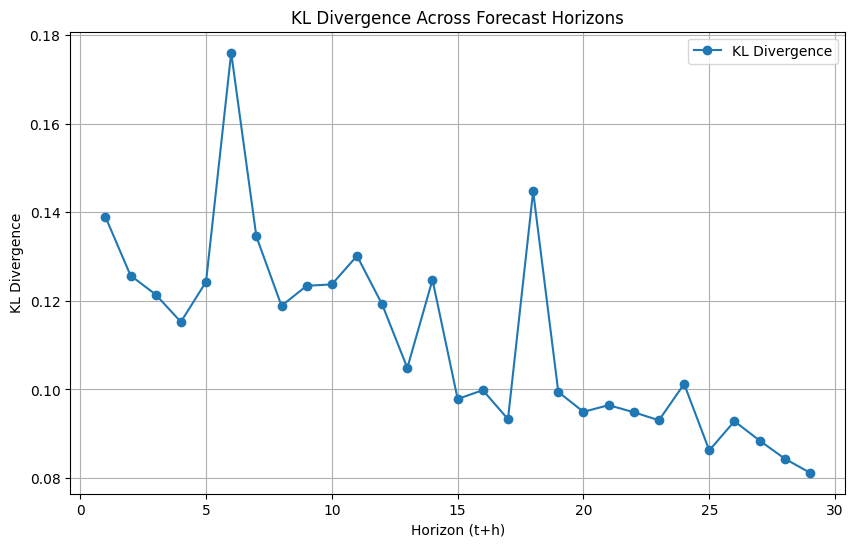

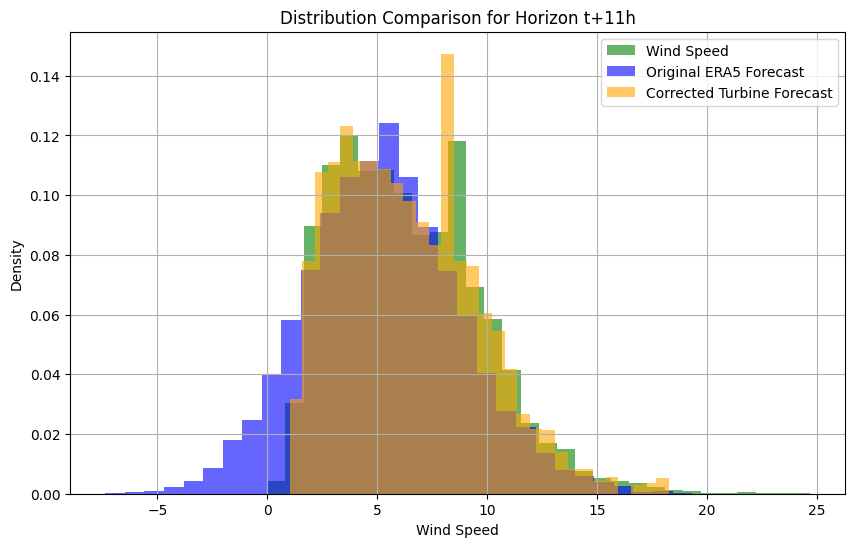

In [40]:
# Evaluate Model
kl_divergences = evaluate_forecasts(
    pd.DataFrame(data_with_wspd_forecasts, columns=[f"fc-{i+1}h" for i in range(29)]),
    pd.DataFrame(corrected_forecasts, columns=y_train.columns),
)
plot_kl_divergence(kl_divergences)

horizon_index = 10
plot_distributions(
    corrected_full_df["Wspd"],
    pd.DataFrame(data_with_wspd_forecasts, columns=[f"fc-{i+1}h" for i in range(29)]),
    pd.DataFrame(corrected_forecasts, columns=y_train.columns),
    horizon_index=horizon_index,
)

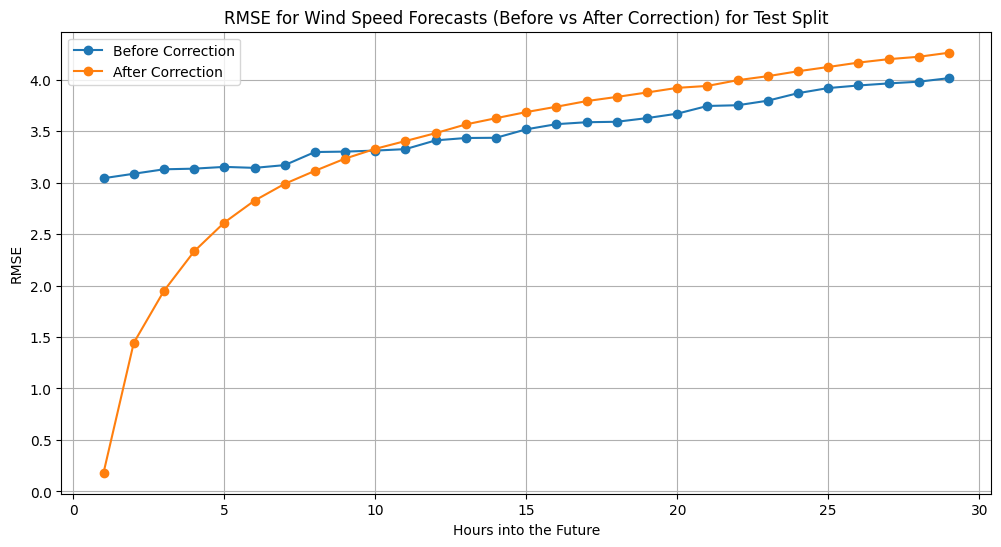

In [41]:
# Considering only the test data
corrected_full_df2 = corrected_full_df[int(0.8 * len(corrected_full_df)) :]

old_rmse_per_horizon = []
new_rmse_per_horizon = []

for i in range(29):
    # Align the forecast with the actual wind speed by shifting
    shifted_ws = corrected_full_df2["Wspd"].shift(-(i + 1))
    old_pred = corrected_full_df2[f"fc-{i+1}h"]

    # Drop NaNs to ensure proper alignment
    valid_idx = shifted_ws.notna() & old_pred.notna()
    shifted_ws = shifted_ws[valid_idx]
    old_pred = old_pred[valid_idx]

    # Calculate RMSE for the original forecast
    old_rmse = np.sqrt(metrics.mean_squared_error(old_pred, shifted_ws))
    old_rmse_per_horizon.append(old_rmse)

    # Calculate RMSE for the corrected forecast
    corrected_pred = corrected_full_df2[f"corrected_t+{i+1}h"]
    valid_idx = corrected_pred.notna() & corrected_full_df2["Wspd"].notna()
    corrected_pred = corrected_pred[valid_idx]
    actual_ws = corrected_full_df2["Wspd"][valid_idx]
    new_rmse = np.sqrt(metrics.mean_squared_error(corrected_pred, actual_ws))
    new_rmse_per_horizon.append(new_rmse)

# Plotting RMSE comparison
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), old_rmse_per_horizon, label="Before Correction", marker="o")
plt.plot(range(1, 30), new_rmse_per_horizon, label="After Correction", marker="o")
plt.xlabel("Hours into the Future")
plt.ylabel("RMSE")
plt.title("RMSE for Wind Speed Forecasts (Before vs After Correction) for Test Split")
plt.legend()
plt.grid(True)
plt.show()

Best parameters for t+10h: OrderedDict([('colsample_bytree', 1.0), ('gamma', 3), ('learning_rate', 0.060206137444380275), ('max_depth', 9), ('min_child_weight', 4), ('n_estimators', 245), ('reg_alpha', 2), ('reg_lambda', 0), ('subsample', 1.0)])


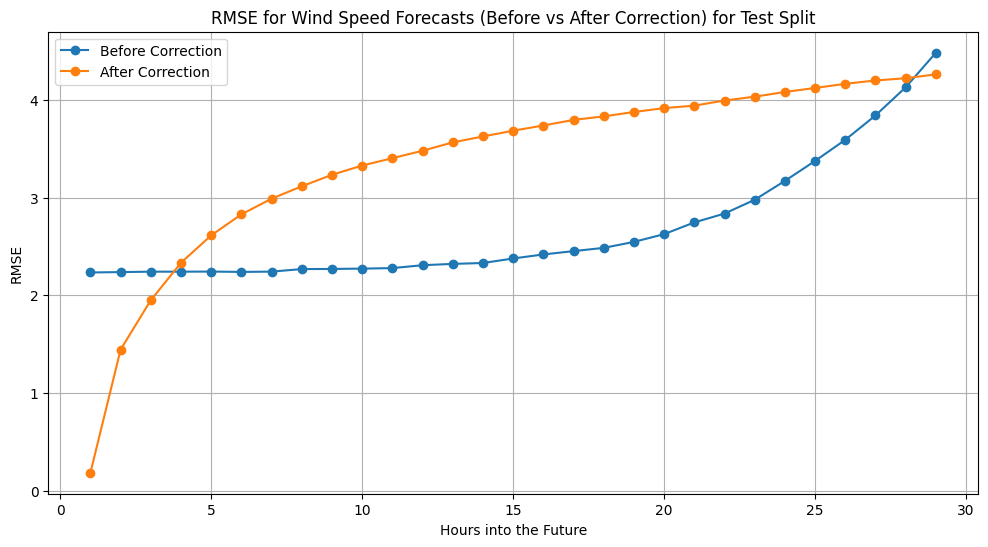

In [42]:
data_with_wspd_forecasts = add_wind_forecasts(
    data, add_noise="exponentially_increasing"
)
X_train, y_train = prepare_features_and_targets_with_collaborative_faiss(
    train_data, True, additional_features
)
X_valid, y_valid = prepare_features_and_targets_with_collaborative_faiss(
    valid_data, False, additional_features
)
search_space = {
    "n_estimators": (50, 300),
    "max_depth": (3, 15),
    "learning_rate": (0.01, 0.3, "log-uniform"),
    "min_child_weight": (1, 10),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "gamma": (0, 5),
    "reg_alpha": (0, 5),
    "reg_lambda": (0, 5),
}

horizon_index = 10
best_params = optimize_xgboost(X_train, y_train, horizon_index)
print(f"Best parameters for t+10h: {best_params}")
multi_regressor = train_multioutput_xgboost(X_train, y_train, best_params)
full_features, _ = prepare_features_and_targets_with_collaborative_faiss(
    data_with_wspd_forecasts, True, additional_features
)
corrected_forecasts = multi_regressor.predict(full_features)
corrected_full_df = append_corrected_forecasts(
    data_with_wspd_forecasts, corrected_forecasts
)
# Considering only the test data
corrected_full_df2 = corrected_full_df[int(0.8 * len(corrected_full_df)) :]

old_rmse_per_horizon = []
new_rmse_per_horizon = []

for i in range(29):
    # Align the forecast with the actual wind speed by shifting
    shifted_ws = corrected_full_df2["Wspd"].shift(-(i + 1))
    old_pred = corrected_full_df2[f"fc-{i+1}h"]

    # Drop NaNs to ensure proper alignment
    valid_idx = shifted_ws.notna() & old_pred.notna()
    shifted_ws = shifted_ws[valid_idx]
    old_pred = old_pred[valid_idx]

    # Calculate RMSE for the original forecast
    old_rmse = np.sqrt(metrics.mean_squared_error(old_pred, shifted_ws))
    old_rmse_per_horizon.append(old_rmse)

    # Calculate RMSE for the corrected forecast
    corrected_pred = corrected_full_df2[f"corrected_t+{i+1}h"]
    valid_idx = corrected_pred.notna() & corrected_full_df2["Wspd"].notna()
    corrected_pred = corrected_pred[valid_idx]
    actual_ws = corrected_full_df2["Wspd"][valid_idx]
    new_rmse = np.sqrt(metrics.mean_squared_error(corrected_pred, actual_ws))
    new_rmse_per_horizon.append(new_rmse)

# Plotting RMSE comparison
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), old_rmse_per_horizon, label="Before Correction", marker="o")
plt.plot(range(1, 30), new_rmse_per_horizon, label="After Correction", marker="o")
plt.xlabel("Hours into the Future")
plt.ylabel("RMSE")
plt.title("RMSE for Wind Speed Forecasts (Before vs After Correction) for Test Split")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
def add_complex_wind_forecasts(
    df: pd.core.frame.DataFrame, add_noise=False, correction_probability=0.05
) -> pd.core.frame.DataFrame:
    """
    Creates synthetic wind speed forecasts with varying levels of noise.
    Includes sporadic correction windows where forecasts become unexpectedly accurate.

    Args:
        df (pd.core.frame.DataFrame): Dataframe with wind turbine data.
        add_noise (str, optional): Type of noise to add. Defaults to False.
                                    Options:
                                    - "linearly_increasing"
                                    - "exponentially_increasing"
                                    - "mimic_real_forecast"
        correction_probability (float, optional): Probability of a correction window at each hour. Defaults to 0.1.

    Returns:
        pd.core.frame.DataFrame: Dataframe with synthetic wind speed forecasts.
    """
    df_2 = df.copy(deep=True)
    # Periods for which to create the forecast
    periods = [*range(1, 30, 1)]

    for period in periods:
        if add_noise == "linearly_increasing":
            # Noise increases linearly with the period
            np.random.seed(8752 + period)
            noise_level = 0.2 * period  # Scale of linear growth
            noise = np.random.randn(len(df)) * noise_level

        elif add_noise == "exponentially_increasing":
            # Noise increases exponentially, simulating compounding uncertainty
            np.random.seed(8752 + period)
            noise_level = 0.15 * (1.03**period)  # Exponential growth
            noise = np.random.randn(len(df)) * noise_level

        elif add_noise == "mimic_real_forecast":
            # Noise starts at a baseline and increases slowly
            np.random.seed(8752 + period)
            noise_level = 2 + 0.05 * period  # Baseline + linear growth
            noise = np.random.randn(len(df)) * noise_level

        else:
            noise = 0

        # Introduce correction windows
        correction_window = np.random.rand(len(df)) < correction_probability
        noise[correction_window] = 0.01  # Very low noise during correction windows

        # Adding forecast noise to the wind speed data
        padding_slice = df_2["Wspd_w"][-period:].to_numpy()
        values = np.concatenate((df_2["Wspd_w"][period:].values, padding_slice)) + noise

        df_2[f"fc-{period}h"] = values

    return df_2

Best parameters for t+10h: OrderedDict([('colsample_bytree', 1.0), ('gamma', 3), ('learning_rate', 0.060206137444380275), ('max_depth', 9), ('min_child_weight', 4), ('n_estimators', 245), ('reg_alpha', 2), ('reg_lambda', 0), ('subsample', 1.0)])


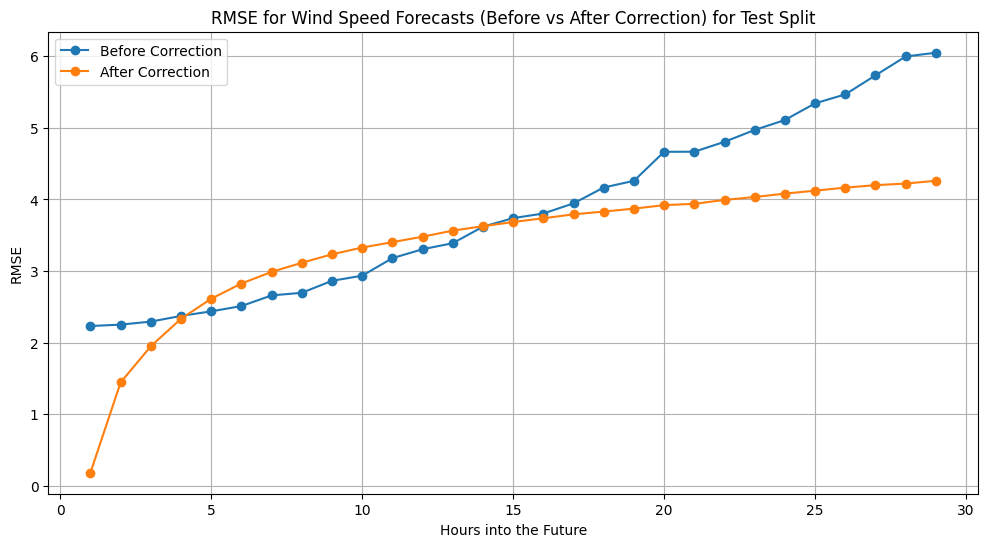

In [44]:
data_with_wspd_forecasts = add_complex_wind_forecasts(
    data, add_noise="linearly_increasing"
)
X_train, y_train = prepare_features_and_targets_with_collaborative_faiss(
    train_data, True, additional_features
)
X_valid, y_valid = prepare_features_and_targets_with_collaborative_faiss(
    valid_data, False, additional_features
)
search_space = {
    "n_estimators": (50, 300),
    "max_depth": (3, 15),
    "learning_rate": (0.01, 0.3, "log-uniform"),
    "min_child_weight": (1, 10),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "gamma": (0, 5),
    "reg_alpha": (0, 5),
    "reg_lambda": (0, 5),
}

horizon_index = 10
best_params = optimize_xgboost(X_train, y_train, horizon_index)
print(f"Best parameters for t+10h: {best_params}")
multi_regressor = train_multioutput_xgboost(X_train, y_train, best_params)
full_features, _ = prepare_features_and_targets_with_collaborative_faiss(
    data_with_wspd_forecasts, True, additional_features
)
corrected_forecasts = multi_regressor.predict(full_features)
corrected_full_df = append_corrected_forecasts(
    data_with_wspd_forecasts, corrected_forecasts
)
# Considering only the test data
corrected_full_df2 = corrected_full_df[int(0.8 * len(corrected_full_df)) :]

old_rmse_per_horizon = []
new_rmse_per_horizon = []

for i in range(29):
    # Align the forecast with the actual wind speed by shifting
    shifted_ws = corrected_full_df2["Wspd"].shift(-(i + 1))
    old_pred = corrected_full_df2[f"fc-{i+1}h"]

    # Drop NaNs to ensure proper alignment
    valid_idx = shifted_ws.notna() & old_pred.notna()
    shifted_ws = shifted_ws[valid_idx]
    old_pred = old_pred[valid_idx]

    # Calculate RMSE for the original forecast
    old_rmse = np.sqrt(metrics.mean_squared_error(old_pred, shifted_ws))
    old_rmse_per_horizon.append(old_rmse)

    # Calculate RMSE for the corrected forecast
    corrected_pred = corrected_full_df2[f"corrected_t+{i+1}h"]
    valid_idx = corrected_pred.notna() & corrected_full_df2["Wspd"].notna()
    corrected_pred = corrected_pred[valid_idx]
    actual_ws = corrected_full_df2["Wspd"][valid_idx]
    new_rmse = np.sqrt(metrics.mean_squared_error(corrected_pred, actual_ws))
    new_rmse_per_horizon.append(new_rmse)

# Plotting RMSE comparison
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), old_rmse_per_horizon, label="Before Correction", marker="o")
plt.plot(range(1, 30), new_rmse_per_horizon, label="After Correction", marker="o")
plt.xlabel("Hours into the Future")
plt.ylabel("RMSE")
plt.title("RMSE for Wind Speed Forecasts (Before vs After Correction) for Test Split")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
data_with_wspd_forecasts.describe()

,Wspd,Etmp,Itmp,Prtv,T2m,Sp,RelH,Wspd_w,Tp,WdirCos,...,fc-20h,fc-21h,fc-22h,fc-23h,fc-24h,fc-25h,fc-26h,fc-27h,fc-28h,fc-29h
count,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,...,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000
mean,6.431889,19.122344,31.059410,-16.769618,10.742697,85380.763819,0.321575,5.292374,0.000006,0.996986,...,5.269160,5.315199,5.347500,5.343731,5.282399,5.217015,5.268192,5.303894,5.248107,5.302905
std,3.319425,12.396222,9.328618,85.480948,13.489028,642.660618,0.175345,2.420204,0.000055,0.019992,...,4.597986,4.808926,4.938834,5.037782,5.229144,5.403467,5.569865,5.838042,5.969133,6.223218
min,0.000000,-8.160000,3.080752,-500.000000,-22.302200,83845.830000,0.031381,0.220342,0.000000,-0.078807,...,-11.257976,-11.641234,-16.174083,-12.832206,-14.546904,-17.316936,-14.974388,-15.681835,-19.145493,-17.277649
25%,3.750000,9.320000,23.020000,-46.490000,-0.002777,84880.350000,0.188008,3.589665,0.000000,0.997660,...,2.219380,2.170815,2.023055,1.962488,1.802099,1.651006,1.569441,1.507299,1.316697,1.250329
50%,6.040000,19.700000,30.000000,-0.320000,12.248932,85305.695000,0.281202,4.988916,0.000000,0.999341,...,5.200850,5.191093,5.255390,5.280486,5.131762,5.161286,5.132915,5.231795,5.156906,5.159740
75%,8.470000,30.010000,38.770000,9.100000,22.055084,85864.340000,0.423150,6.749696,0.000000,0.999887,...,8.300021,8.417728,8.650872,8.658504,8.662951,8.744769,8.871566,9.033143,9.098822,9.346694
max,24.670000,44.940000,54.740000,499.680000,37.662262,87489.220000,0.930388,16.113009,0.001441,1.000000,...,24.523806,25.169368,24.840905,26.348134,28.976585,26.316404,29.012995,27.120983,35.069850,34.838602


In [46]:
corrected_full_df.describe()

,Wspd,Etmp,Itmp,Prtv,T2m,Sp,RelH,Wspd_w,Tp,WdirCos,...,corrected_t+20h,corrected_t+21h,corrected_t+22h,corrected_t+23h,corrected_t+24h,corrected_t+25h,corrected_t+26h,corrected_t+27h,corrected_t+28h,corrected_t+29h
count,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,10773.000000,...,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000
mean,6.431889,19.122344,31.059410,-16.769618,10.742697,85380.763819,0.321575,5.292374,0.000006,0.996986,...,6.433583,6.431554,6.431759,6.430197,6.428097,6.428946,6.428490,6.429006,6.428004,6.428287
std,3.319425,12.396222,9.328618,85.480948,13.489028,642.660618,0.175345,2.420204,0.000055,0.019992,...,3.210866,3.206098,3.209092,3.206322,3.200451,3.203997,3.206226,3.209228,3.206978,3.208744
min,0.000000,-8.160000,3.080752,-500.000000,-22.302200,83845.830000,0.031381,0.220342,0.000000,-0.078807,...,1.010392,1.010168,1.014497,1.010516,1.009417,1.011234,1.010835,1.012696,1.013240,1.011828
25%,3.750000,9.320000,23.020000,-46.490000,-0.002777,84880.350000,0.188008,3.589665,0.000000,0.997660,...,3.810785,3.808982,3.812624,3.808914,3.811922,3.810670,3.809484,3.808950,3.808966,3.810855
50%,6.040000,19.700000,30.000000,-0.320000,12.248932,85305.695000,0.281202,4.988916,0.000000,0.999341,...,6.082451,6.081583,6.082455,6.048289,6.045190,6.049750,6.041529,6.048851,6.041981,6.046382
75%,8.470000,30.010000,38.770000,9.100000,22.055084,85864.340000,0.423150,6.749696,0.000000,0.999887,...,8.473913,8.420282,8.420441,8.411755,8.417978,8.414440,8.412250,8.411526,8.410509,8.404782
max,24.670000,44.940000,54.740000,499.680000,37.662262,87489.220000,0.930388,16.113009,0.001441,1.000000,...,18.265078,18.551737,18.188179,18.213699,18.297991,18.202602,18.161226,18.204908,18.193066,18.201067


### Step 3 - Corresponding Model Improvements

In [47]:
corrected_full_df = corrected_full_df.drop([f"fc-{i+1}h" for i in range(29)], axis=1)

In [48]:
def create_transformer_model(num_features: int, days_in_past: int) -> tf.keras.Model:
    """Creates a Transformer-based model for time series prediction.

    Args:
        num_features (int): Number of features used for prediction.
        days_in_past (int): Number of days into the past to predict next 24 hours.

    Returns:
        tf.keras.Model: The uncompiled model.
    """
    OUT_STEPS = 24
    D_MODEL = 64  # Dimension of the transformer embeddings
    NUM_HEADS = 6
    NUM_LAYERS = 3
    DROPOUT_RATE = 0.4
    L2_Regulation = 0.1

    # Input
    inputs = tf.keras.Input(shape=(days_in_past * 24, num_features))

    # Positional Encoding
    positional_encoding = tf.keras.layers.Embedding(
        input_dim=days_in_past * 24, output_dim=D_MODEL
    )(tf.range(days_in_past * 24))

    x = tf.keras.layers.Dense(D_MODEL)(inputs)  # Linear projection to embedding space
    x = x + positional_encoding

    # Transformer Encoder Blocks
    for _ in range(NUM_LAYERS):
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=D_MODEL, dropout=DROPOUT_RATE
        )(x, x)
        attention_output = tf.keras.layers.Dropout(DROPOUT_RATE)(attention_output)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

        # Feedforward Network
        ffn_output = tf.keras.layers.Dense(
            D_MODEL * 4,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(L2_Regulation),
        )(x)
        ffn_output = tf.keras.layers.Dense(
            D_MODEL, kernel_regularizer=tf.keras.regularizers.l2(L2_Regulation)
        )(ffn_output)
        ffn_output = tf.keras.layers.Dropout(DROPOUT_RATE)(ffn_output)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Output Head
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(
        OUT_STEPS * 1, kernel_regularizer=tf.keras.regularizers.l2(L2_Regulation)
    )(x)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, 1])(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


def compile_and_fit(
    model: tf.keras.Model, window: WindowGenerator, patience: int = 4
) -> tf.keras.callbacks.History:
    """Compiles and trains a model given a patience threshold.

    Args:
        model (tf.keras.Model): The model to train.
        window (WindowGenerator): The windowed data.
        patience (int, optional): Patience threshold to stop training. Defaults to 2.

    Returns:
        tf.keras.callbacks.History: The training history.
    """
    EPOCHS = 50

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=6e-4, decay_steps=1000, decay_rate=0.6
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=optimizer,
    )

    tf.random.set_seed(432)
    np.random.seed(432)
    random.seed(432)

    history = model.fit(
        window.train,
        epochs=EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )

    if len(history.epoch) < EPOCHS:
        print(
            "\nTraining stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps."
        )

    return history


def train_trans_model(
    data: pd.core.frame.DataFrame, features: List[str], days_in_past: int
) -> Tuple[WindowGenerator, tf.keras.Model, DataSplits]:
    """Trains the Conv-LSTM model for time series prediction.

    Args:
        data (pd.core.frame.DataFrame): The dataframe to be used.
        data (list[str]): The features to use for forecasting.
        days_in_past (int): How many days in the past to use to forecast the next 24 hours.

    Returns:
        tuple: The windowed dataset, the model that handles the forecasting logic and the data used.
    """
    data_splits = train_val_test_split(data[features])

    train_data, val_data, test_data, train_mean, train_std = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
        data_splits.train_mean,
        data_splits.train_std,
    )

    window = generate_window(train_data, val_data, test_data, days_in_past)
    num_features = window.train_df.shape[1]

    model = create_transformer_model(num_features, days_in_past)
    history = compile_and_fit(model, window)

    return window, model, data_splits

In [49]:
corrected_full_df.dropna(inplace=True)

In [50]:
features = list(corrected_full_df.columns)
window, model, _data_splits = train_trans_model(
    corrected_full_df, features, days_in_past=1
)
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 36.6710 - val_loss: 2.8455
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 1.7646 - val_loss: 0.5120
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.4953 - val_loss: 0.3879
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.4063 - val_loss: 0.3652
Epoch 5/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.3795 - val_loss: 0.3572
Epoch 6/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.3635 - val_loss: 0.3518
Epoch 7/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.3518 - val_loss: 0.3458
Epoch 8/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.3399 - val_loss: 0.3437
Epoch 9/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.3324 - val_loss: 0.3397
Epoch 10/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.3262 - val_loss: 0.3380
Epoch 11/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.3188 - val_loss: 0.3364
Epoch 12/50
234/234 ━━━━━━━━━

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…